# Aula Prática 6 - Autoencoders


Nesta aula prática, exploraremos Autoencoders e Variational Autoencoders (VAEs), duas importantes arquiteturas de redes neurais utilizadas para compressão de dados, aprendizado não supervisionado e geração de dados sintéticos. Ambas as técnicas são amplamente aplicadas em domínios como redução de dimensionalidade, detecção de anomalias e geração de imagens.

Autoencoders são redes neurais treinadas para comprimir dados de entrada em uma representação de menor dimensão (o código) e, em seguida, reconstruir os dados originais a partir dessa representação. O principal objetivo de um autoencoder é aprender uma representação compacta dos dados, mantendo ao máximo as características mais relevantes para a reconstrução.

Por outro lado, Variational Autoencoders (VAEs) estendem o conceito de autoencoders ao incorporar uma abordagem probabilística. Eles são capazes de gerar novos dados a partir de distribuições aprendidas, tornando-se uma ferramenta poderosa para tarefas de geração de dados, como a síntese de imagens. O VAE não apenas codifica a entrada, mas também aprende uma distribuição de probabilidade que pode ser amostrada para gerar novas instâncias realistas.

# Autoencoder Linear vs Autoencoder Convolutional

### Importando Bibliotecas

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split, SubsetRandomSampler

# Definindo o estilo do gráfico
plt.style.use('fivethirtyeight')

from tqdm import tqdm

In [ ]:
# device torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


### Configurando Dataset e Dataloader

In [ ]:



# Transformações
tensor_transform = transforms.ToTensor()

# Download do dataset MNIST
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tensor_transform)

# Definindo as proporções: 80% treino, 10% validação, 10% teste
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Dividindo o dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Criando DataLoaders para treino, validação e teste
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

# Verificando os tamanhos dos datasets
print(f"Tamanho do dataset de treino: {len(train_loader.dataset)}")
print(f"Tamanho do dataset de validação: {len(val_loader.dataset)}")
print(f"Tamanho do dataset de teste: {len(test_loader.dataset)}")



Tamanho do dataset de treino: 48000
Tamanho do dataset de validação: 6000
Tamanho do dataset de teste: 6000


### Construindo Autoencoder Linear

In [ ]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()

		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 9)
		)

		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(9, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 28 * 28),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


### Construindo Autoencoder Convolucional

In [ ]:


class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()

        # Encoder: Convolutional layers to compress the image
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)  # 7x7 -> 1x1
        )

        # Decoder: Transposed Convolutional layers to reconstruct the image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),  # 1x1 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Saída entre 0 e 1
        )

    def forward(self, x):
        # Passa pelo encoder
        encoded = self.encoder(x)
        # Passa pelo decoder
        decoded = self.decoder(encoded)
        return decoded

### Funções Auxiliares no Treinamento

In [ ]:
# Função de treinamento
def train_model(model, train_loader, loss_function, optimizer, device, convolutional = True):
    model.train()  # Modo de treinamento
    total_loss = 0
    for image, _ in tqdm(train_loader, desc="Training", leave=False):

        if convolutional:
          # Mover as imagens para o dispositivo (GPU ou CPU)
          image = image.to(device)
        else:
          image = image.reshape(-1, 28*28).to(device)

        # Forward pass (saída do autoencoder)
        reconstructed = model(image)

        # Calculando a perda
        loss = loss_function(reconstructed, image)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumulando a perda total
        total_loss += loss.item()

    # Retorna a perda média
    return total_loss / len(train_loader)

# Função de avaliação (validação)
def evaluate_model(model, val_loader, loss_function, device, convolutional = True):
    model.eval()  # Modo de avaliação (desabilita dropout, batchnorm, etc.)
    total_loss = 0
    with torch.no_grad():  # Desabilita a computação de gradientes
        for image, _ in tqdm(val_loader, desc="Validation", leave=False):
            if convolutional:
              # Mover as imagens para o dispositivo (GPU ou CPU)
              image = image.to(device)
            else:
              image = image.reshape(-1, 28*28).to(device)

            # Forward pass (saída do autoencoder)
            reconstructed = model(image)

            # Calculando a perda
            loss = loss_function(reconstructed, image)

            # Acumulando a perda total
            total_loss += loss.item()

    # Retorna a perda média
    return total_loss / len(val_loader)



# Função principal de treinamento e validação
def run_training(model, train_loader, val_loader, loss_function, optimizer, device, convolutional = True, epochs=50):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Treinamento para a época atual
        train_loss = train_model(model, train_loader, loss_function, optimizer, device, convolutional)

        # Validação para a época atual
        val_loss = evaluate_model(model, val_loader, loss_function, device, convolutional)

        # Armazenando as perdas
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print das métricas a cada época
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses




### Função para Visualização dos Resultados

In [ ]:
# Função para visualizar uma amostra aleatória de imagens do conjunto de teste
def visualize_test_images(model, test_loader, num_images, device, convolutional=True):
    model.eval()  # Coloca o modelo em modo de avaliação
    with torch.no_grad():  # Não precisa calcular gradientes durante a inferência
        for batch_idx, (image, _) in enumerate(test_loader):

            if convolutional:
                # Mover as imagens para o dispositivo (GPU ou CPU)
                image = image.to(device)
            else:
                image = image.reshape(-1, 28*28).to(device)

            # Reconstruir as imagens usando o modelo
            reconstructed = model(image)

            # Selecionar uma amostra aleatória de índices
            indices = torch.randperm(image.size(0))[:num_images]

            # Exibir as imagens originais e reconstruídas da amostra aleatória
            for i, idx in enumerate(indices):
                # Original
                original_image = image[idx].detach().cpu().reshape(28, 28)

                # Reconstruída
                reconstructed_image = reconstructed[idx].detach().cpu().reshape(28, 28)

                # Criando subplots: 1 linha, 2 colunas (original e reconstruída)
                fig, ax = plt.subplots(1, 2, figsize=(4, 2))  # Reduzir o tamanho da figura

                # Exibindo a imagem original
                ax[0].imshow(original_image, cmap='gray')
                ax[0].set_title(f"Original Image {i+1}", fontsize=10)  # Tamanho menor do título
                ax[0].axis('off')  # Remove os eixos

                # Exibindo a imagem reconstruída
                ax[1].imshow(reconstructed_image, cmap='gray')
                ax[1].set_title(f"Reconstructed Image {i+1}", fontsize=10)  # Tamanho menor do título
                ax[1].axis('off')  # Remove os eixos

                # Exibir a figura
                plt.show()

            # Limitar a exibição ao número de imagens desejado
            if batch_idx * test_loader.batch_size >= num_images:
                break


## Linear

In [ ]:
# Model Initialization
model_lin = AE().to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model_lin.parameters(),
							lr = 1e-3,
							weight_decay = 1e-8)


In [ ]:
# Agora rodamos o treinamento
train_losses, val_losses = run_training(model_lin, train_loader,
                                        val_loader,
                                        loss_function,
                                        optimizer,
                                        device,
                                        convolutional = False,
                                        epochs=20)



Epoch [1/20] - Train Loss: 0.0872, Val Loss: 0.0629


Epoch [2/20] - Train Loss: 0.0596, Val Loss: 0.0551


Epoch [3/20] - Train Loss: 0.0511, Val Loss: 0.0473


Epoch [4/20] - Train Loss: 0.0448, Val Loss: 0.0415


Epoch [5/20] - Train Loss: 0.0402, Val Loss: 0.0385


Epoch [6/20] - Train Loss: 0.0375, Val Loss: 0.0358


Epoch [7/20] - Train Loss: 0.0353, Val Loss: 0.0344


Epoch [8/20] - Train Loss: 0.0341, Val Loss: 0.0332


Epoch [9/20] - Train Loss: 0.0332, Val Loss: 0.0325


Epoch [10/20] - Train Loss: 0.0324, Val Loss: 0.0318


Epoch [11/20] - Train Loss: 0.0317, Val Loss: 0.0311


Epoch [12/20] - Train Loss: 0.0308, Val Loss: 0.0301


Epoch [13/20] - Train Loss: 0.0299, Val Loss: 0.0293


Epoch [14/20] - Train Loss: 0.0293, Val Loss: 0.0288


Epoch [15/20] - Train Loss: 0.0289, Val Loss: 0.0284


Epoch [16/20] - Train Loss: 0.0285, Val Loss: 0.0282


Epoch [17/20] - Train Loss: 0.0281, Val Loss: 0.0278


Epoch [18/20] - Train Loss: 0.0278, Val Loss: 0.0277


Epoch [19/20] - Train Loss: 0.0276, Val Loss: 0.0274


Epoch [20/20] - Train Loss: 0.0273, Val Loss: 0.0270


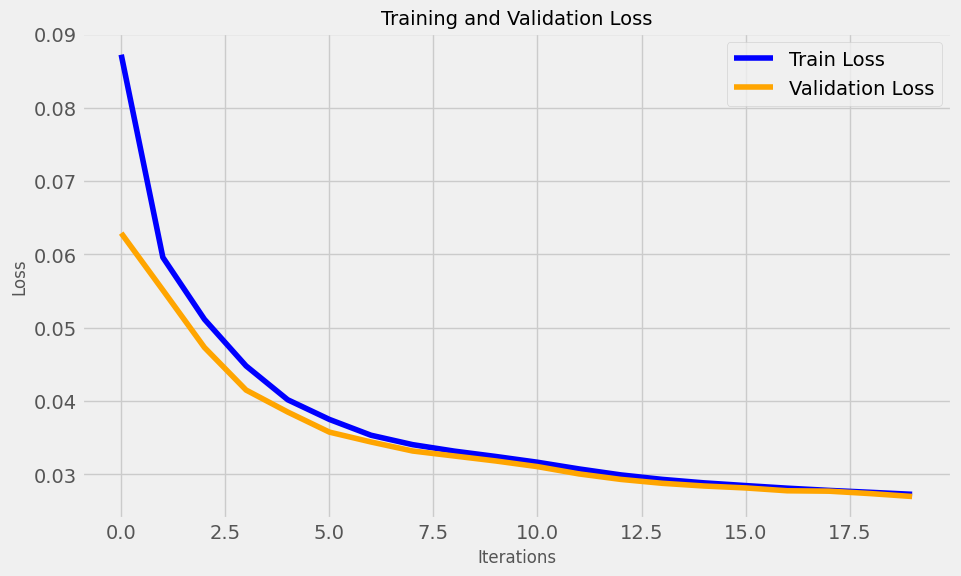

In [ ]:

# Configurações do gráfico
plt.figure(figsize=(10, 6))  # Ajuste o tamanho da figura
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)

# Plotando os últimos 100 valores de loss de treino e validação
plt.plot(train_losses[-100:], label='Train Loss', color='blue')
plt.plot(val_losses[-100:], label='Validation Loss', color='orange')

# Adicionando legenda
plt.legend()

# Exibir o gráfico
plt.show()


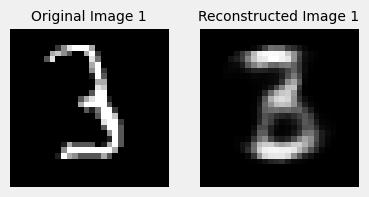

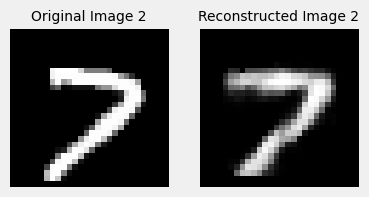

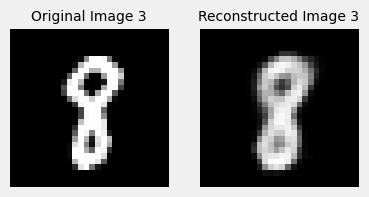

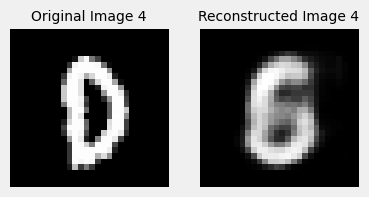

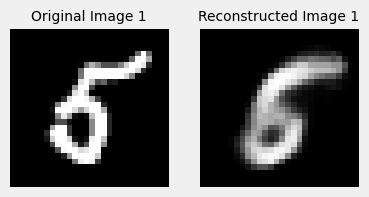

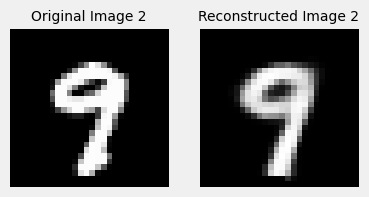

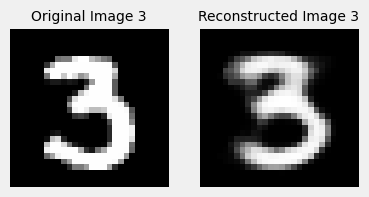

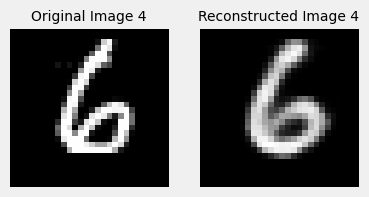

In [ ]:
# Visualizando imagens do conjunto de teste com títulos menores
visualize_test_images(model_lin, test_loader, num_images=4, device=device, convolutional=False)

## Convolutional

In [ ]:
model_conv = ConvAE().to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model_conv.parameters(),
							lr = 1e-3,
							weight_decay = 1e-8)


In [ ]:


# Agora rodamos o treinamento
train_losses, val_losses = run_training(model_conv, train_loader,
                                        val_loader,
                                        loss_function,
                                        optimizer,
                                        device,
                                        convolutional = True,
                                        epochs=20)


Epoch [1/20] - Train Loss: 0.0855, Val Loss: 0.0509


Epoch [2/20] - Train Loss: 0.0295, Val Loss: 0.0172


Epoch [3/20] - Train Loss: 0.0136, Val Loss: 0.0107


Epoch [4/20] - Train Loss: 0.0095, Val Loss: 0.0082


Epoch [5/20] - Train Loss: 0.0076, Val Loss: 0.0068


Epoch [6/20] - Train Loss: 0.0065, Val Loss: 0.0060


Epoch [7/20] - Train Loss: 0.0057, Val Loss: 0.0053


Epoch [8/20] - Train Loss: 0.0051, Val Loss: 0.0049


Epoch [9/20] - Train Loss: 0.0047, Val Loss: 0.0045


Epoch [10/20] - Train Loss: 0.0044, Val Loss: 0.0042


Epoch [11/20] - Train Loss: 0.0041, Val Loss: 0.0040


Epoch [12/20] - Train Loss: 0.0039, Val Loss: 0.0038


Epoch [13/20] - Train Loss: 0.0037, Val Loss: 0.0036


Epoch [14/20] - Train Loss: 0.0035, Val Loss: 0.0035


Epoch [15/20] - Train Loss: 0.0034, Val Loss: 0.0034


Epoch [16/20] - Train Loss: 0.0033, Val Loss: 0.0032


Epoch [17/20] - Train Loss: 0.0032, Val Loss: 0.0031


Epoch [18/20] - Train Loss: 0.0031, Val Loss: 0.0031


Epoch [19/20] - Train Loss: 0.0030, Val Loss: 0.0030


Epoch [20/20] - Train Loss: 0.0030, Val Loss: 0.0029


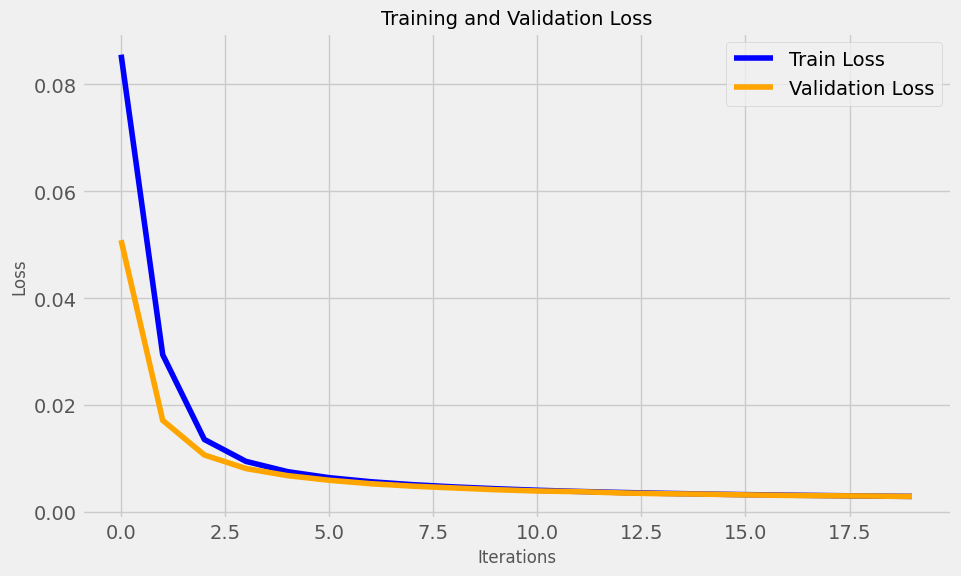

In [ ]:

# Configurações do gráfico
plt.figure(figsize=(10, 6))  # Ajuste o tamanho da figura
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)

# Plotando os últimos 100 valores de loss de treino e validação
plt.plot(train_losses[-100:], label='Train Loss', color='blue')
plt.plot(val_losses[-100:], label='Validation Loss', color='orange')

# Adicionando legenda
plt.legend()

# Exibir o gráfico
plt.show()

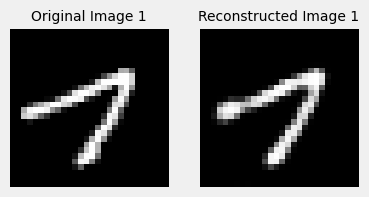

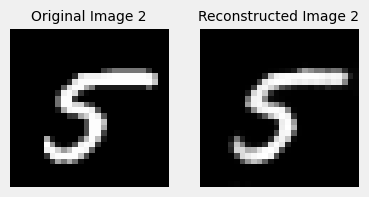

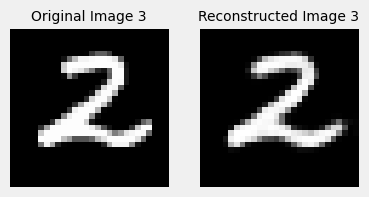

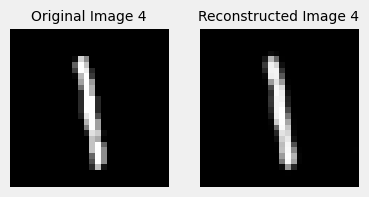

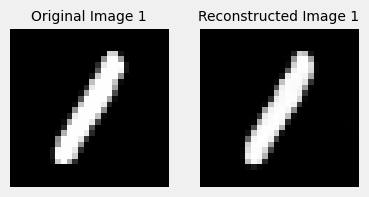

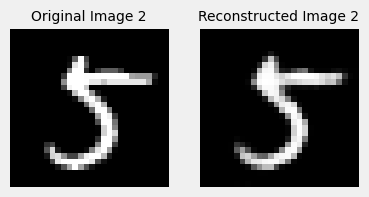

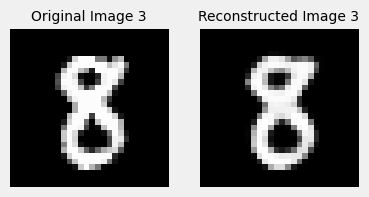

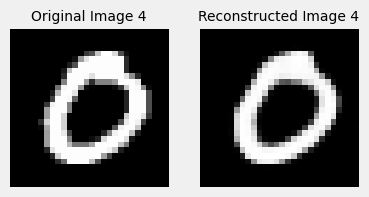

In [ ]:


# Visualizando imagens do conjunto de teste com títulos menores
visualize_test_images(model_conv, test_loader, num_images=4, device=device, convolutional=True)

# Varitional Autoencoders

Antes de seguir adiante, tente fazer a implementação do VAE. A resposta está no tutorial ou no código abaixo, para que você possa consultar quando encontrar alguma dificuldade.

referência: https://debuggercafe.com/getting-started-with-variational-autoencoders-using-pytorch/

### Importando Bibliotecas

In [ ]:
import torch.nn.functional as F
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

### Definindo Hiperparâmetros

In [ ]:
epochs = 20
lr = 0.0001
features = 2

### Construindo o Modelo VAE

In [ ]:

# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()

        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)

        # decoder
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var

### Criando o Modelo, Otimizador e Loss

In [ ]:
model_vae = LinearVAE().to(device)
optimizer = optim.Adam(model_vae.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

### Final Loss usando divergencia de Kullback-Leibler

In [ ]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### Funções Auxiliares no Treinamento

In [ ]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataset)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [ ]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_dataset)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()

    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

### Treinando o Modelo

In [ ]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model_vae, train_loader)
    val_epoch_loss = validate(model_vae, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20


188it [00:06, 30.52it/s]                         
24it [00:00, 36.79it/s]


Train Loss: 296.5356
Val Loss: 221.8279
Epoch 2 of 20


188it [00:05, 34.95it/s]                         
24it [00:00, 39.75it/s]                        


Train Loss: 209.3556
Val Loss: 198.9527
Epoch 3 of 20


188it [00:06, 30.60it/s]                         
24it [00:00, 38.52it/s]                        


Train Loss: 196.0274
Val Loss: 191.3242
Epoch 4 of 20


188it [00:05, 34.68it/s]
24it [00:00, 38.44it/s]                        


Train Loss: 190.4025
Val Loss: 186.9739
Epoch 5 of 20


188it [00:06, 30.39it/s]                         
24it [00:00, 38.54it/s]                        


Train Loss: 186.6984
Val Loss: 183.7336
Epoch 6 of 20


188it [00:05, 35.18it/s]                         
24it [00:00, 38.69it/s]                        


Train Loss: 183.8187
Val Loss: 181.0802
Epoch 7 of 20


188it [00:06, 30.98it/s]                         
24it [00:00, 38.37it/s]                        


Train Loss: 181.4974
Val Loss: 178.9917
Epoch 8 of 20


188it [00:05, 35.17it/s]                         
24it [00:00, 38.25it/s]                        


Train Loss: 179.5500
Val Loss: 177.0585
Epoch 9 of 20


188it [00:06, 31.10it/s]                         
24it [00:00, 38.74it/s]                        


Train Loss: 177.7939
Val Loss: 175.4192
Epoch 10 of 20


188it [00:05, 35.38it/s]
24it [00:00, 35.61it/s]                        


Train Loss: 176.1823
Val Loss: 173.9581
Epoch 11 of 20


188it [00:06, 31.06it/s]                         
24it [00:00, 38.84it/s]                        


Train Loss: 174.7350
Val Loss: 172.5698
Epoch 12 of 20


188it [00:05, 35.33it/s]                         
24it [00:00, 38.55it/s]                        


Train Loss: 173.3947
Val Loss: 171.4165
Epoch 13 of 20


188it [00:06, 30.96it/s]
24it [00:00, 37.73it/s]                        


Train Loss: 172.2445
Val Loss: 170.2451
Epoch 14 of 20


188it [00:05, 35.26it/s]
24it [00:00, 31.38it/s]                        


Train Loss: 171.1535
Val Loss: 169.2578
Epoch 15 of 20


188it [00:06, 31.27it/s]                         
24it [00:00, 39.54it/s]                        


Train Loss: 170.1953
Val Loss: 168.3534
Epoch 16 of 20


188it [00:05, 33.26it/s]                         
24it [00:01, 14.72it/s]


Train Loss: 169.2920
Val Loss: 167.4683
Epoch 17 of 20


188it [00:05, 34.51it/s]                         
24it [00:00, 39.03it/s]                        


Train Loss: 168.4725
Val Loss: 166.7437
Epoch 18 of 20


188it [00:05, 31.74it/s]                         
24it [00:00, 29.47it/s]                        


Train Loss: 167.7610
Val Loss: 166.1354
Epoch 19 of 20


188it [00:05, 35.00it/s]
24it [00:00, 38.47it/s]                        


Train Loss: 167.1319
Val Loss: 165.4339
Epoch 20 of 20


188it [00:06, 30.79it/s]
24it [00:00, 38.32it/s]                        

Train Loss: 166.5224
Val Loss: 164.9184


### Visualizando Losses

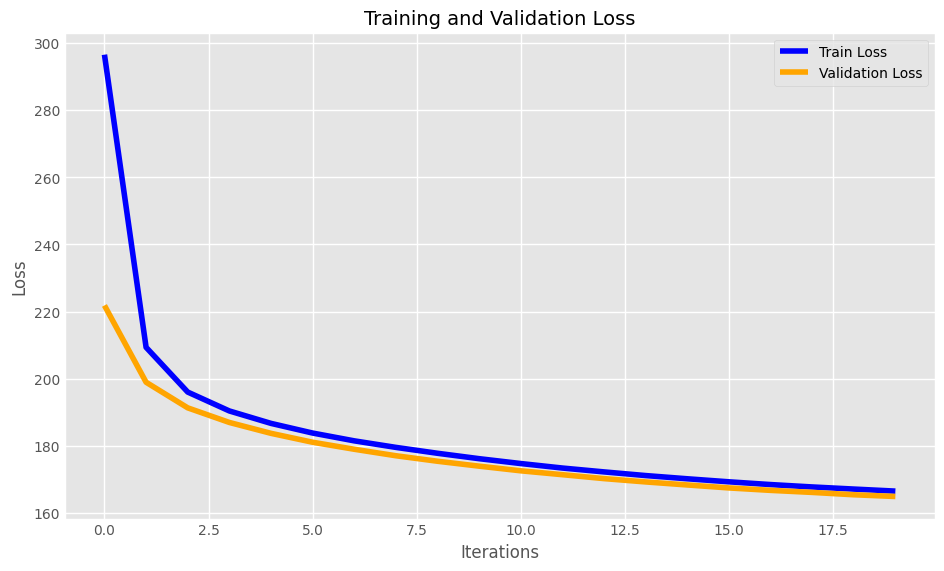

In [ ]:

# Configurações do gráfico
plt.figure(figsize=(10, 6))  # Ajuste o tamanho da figura
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)

# Plotando os últimos 100 valores de loss de treino e validação
plt.plot(train_loss[-100:], label='Train Loss', color='blue')
plt.plot(val_loss[-100:], label='Validation Loss', color='orange')

# Adicionando legenda
plt.legend()

# Exibir o gráfico
plt.show()

### Reconstruções

In [ ]:
#Função para visualizar uma amostra aleatória de imagens do conjunto de teste
def visualize_test_images_vae(model, test_loader, num_images, device, convolutional=True):
    model.eval()  # Coloca o modelo em modo de avaliação
    with torch.no_grad():  # Não precisa calcular gradientes durante a inferência
        for batch_idx, (image, _) in enumerate(test_loader):

            if convolutional:
                # Mover as imagens para o dispositivo (GPU ou CPU)
                image = image.to(device)
            else:
                image = image.reshape(-1, 28*28).to(device)

            # Reconstruir as imagens usando o modelo
            reconstructed = model(image)

            # Selecionar uma amostra aleatória de índices
            indices = torch.randperm(image.size(0))[:num_images]

            # Exibir as imagens originais e reconstruídas da amostra aleatória
            for i, idx in enumerate(indices):
                # Original
                original_image = image[idx].detach().cpu().reshape(28, 28)


                # Reconstruída
                reconstructed_image = reconstructed[0][idx].detach().cpu().reshape(28, 28)


                # Criando subplots: 1 linha, 2 colunas (original e reconstruída)
                fig, ax = plt.subplots(1, 2, figsize=(4, 2))  # Reduzir o tamanho da figura

                # Exibindo a imagem original
                ax[0].imshow(original_image, cmap='gray')
                ax[0].set_title(f"Original Image {i+1}", fontsize=10)  # Tamanho menor do título
                ax[0].axis('off')  # Remove os eixos

                # Exibindo a imagem reconstruída
                ax[1].imshow(reconstructed_image, cmap='gray')
                ax[1].set_title(f"Reconstructed Image {i+1}", fontsize=10)  # Tamanho menor do título
                ax[1].axis('off')  # Remove os eixos

                # Exibir a figura
                plt.show()

            # Limitar a exibição ao número de imagens desejado
            if batch_idx * test_loader.batch_size >= num_images:
                break

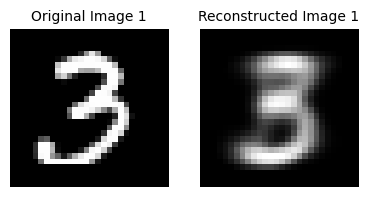

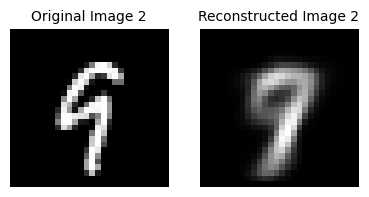

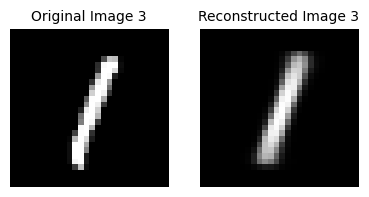

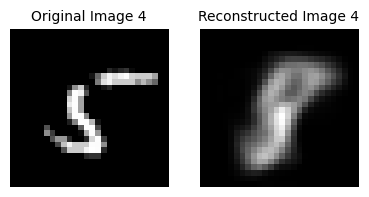

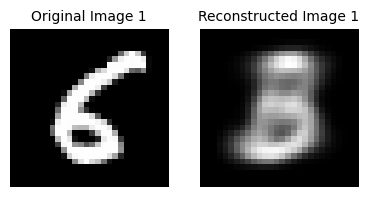

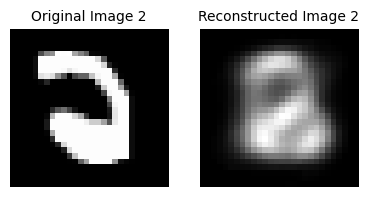

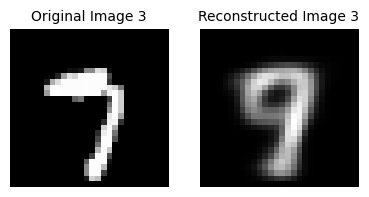

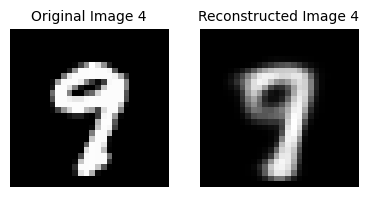

In [ ]:
# Visualizando imagens do conjunto de teste com títulos menores
visualize_test_images_vae(model_vae, test_loader, num_images=4, device=device, convolutional=False)
